# Studying Publication Driven Events Across Multiple Companies

Now that we have a framework for testing the CAR returns deviation from the popoulation mean, we can take our hypothesis (and null hypothesis), and test it on other Quantum Computing related companies. For this analysis, we have included four companies: *Rigetti* and *D-Wave* as two pure play companies, and *IBM* and *Amazon* as larger corporations with quantum computing research arms. We will look at Rigetti and Amazon first, and then look at D-Wave and IBM as two stressing cases for our current framework.

## Packages

For this, the pieces of code that appeared in `01_IonQ_Starter_Exploration.ipynb` and `02_IonQ_Rolling_Regression.ipynb` have been modularized under the `src` directory. Under `arc/analysis` exist the scripts that handle any calculations (`utils.py`), statistical anlysis (`stats.py`), or data visualization (`visualization.py`). For scripts handling data scraping/retrieving and formatting, those will be found under `src/data` in the `data_utils.py` file. Finally, to have each analysis contained in an object (in case future use needed in this notebook), under `src/analysis` exists the class `EventStudy.py` file, where the methods serve as more specific to this study implementations of the modularized scripts described before, and save intermediate results as class attributes should later analysis adde to this notebook require them (or analysis in other notebooks).

The packages and functions needed are imported below:

In [1]:
import sys
sys.path.append('../')
from src.analysis.EventStudy import EventStudy
from src.data.data_utils import get_returns, scrape_arxiv, scrape_arxiv_raw
from src.analysis.visualization import plot_test_results
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

## Rigetti

In [3]:
ticker = 'RGTI'
rgti_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=rgti_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv(query="Quantum AND Rigetti", start_date="2021-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
windows = [i for i in range(36)]

ev_rgti = EventStudy(ticker, market_returns, windows)

In [5]:
ev_rgti.fit_residuals(stock_returns=rgti_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


In [6]:
filtered_dates = []
for idx in rgti_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('10d')):
            filtered_dates.append(idx)

results = ev_rgti.event_single_test(event_dates=arxiv_df.index)
mean_random, std_random = ev_rgti.random_single_test(filtered_dates=filtered_dates, n=len(arxiv_df))

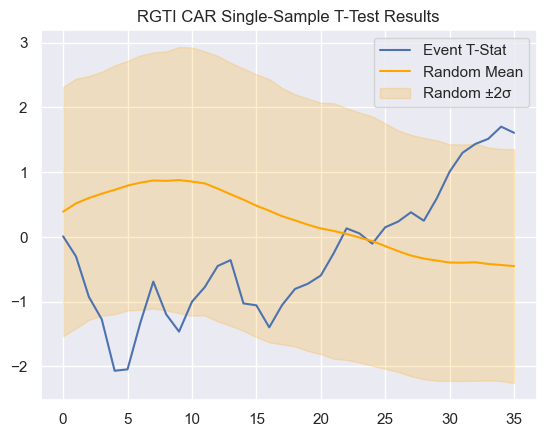

In [7]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [8]:
mean_two_sample, std_two_sample = ev_rgti.event_two_sample_test(event_dates=arxiv_df.index, filtered_dates=filtered_dates, n=len(arxiv_df))

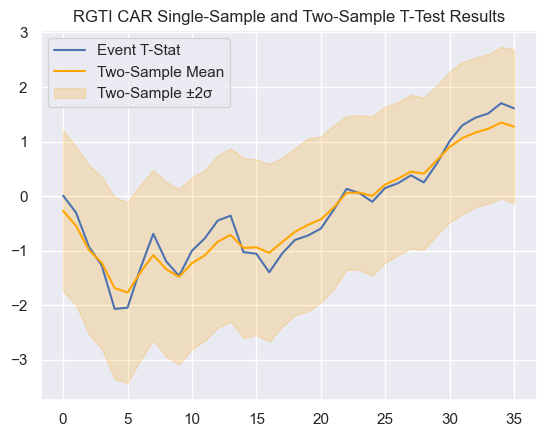

In [9]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

The above figures indicate that perhaps a longer window then IonQ required is needed to realize possible publication correlated returns. If we quickly look at the p-values for Rigetti single-sample event t-test:

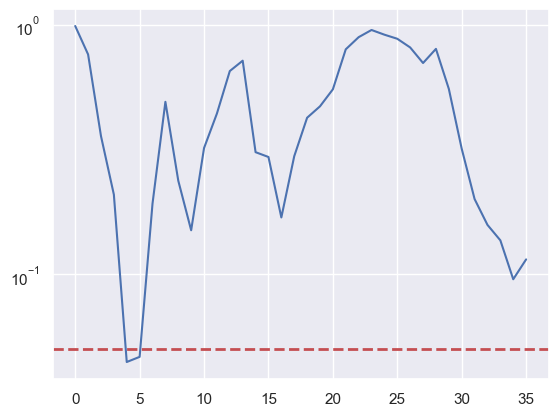

In [12]:
_ = results['p_value'].plot(logy=True)
_ = plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p=0.05')

We can see that from the single-sample test (which the two-sample test mean closely follows the t-scores of), the p-value of the tests points to us not being able to reject the null hypothesis that returns are independent of the publication events for Rigetti.

## Amazon

In [13]:
ticker = 'AMZN'
amzn_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=amzn_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv(query="Quantum AND AWS Center for Quantum Computing", start_date="2021-01-01", max_results=500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
windows = [i for i in range(36)]

ev_amzn = EventStudy(ticker, market_returns, windows)

In [15]:
ev_amzn.fit_residuals(stock_returns=amzn_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


In [16]:
filtered_dates = []
for idx in amzn_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('10d')):
            filtered_dates.append(idx)

results = ev_amzn.event_single_test(event_dates=arxiv_df.index)
mean_random, std_random = ev_amzn.random_single_test(filtered_dates=filtered_dates, n=len(arxiv_df))

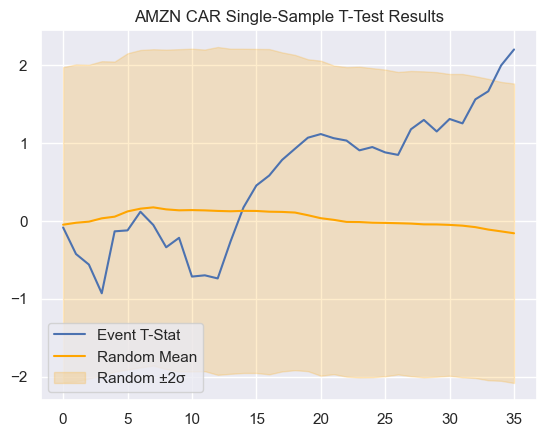

In [17]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [18]:
mean_two_sample, std_two_sample = ev_amzn.event_two_sample_test(event_dates=arxiv_df.index, filtered_dates=filtered_dates, n=len(arxiv_df))

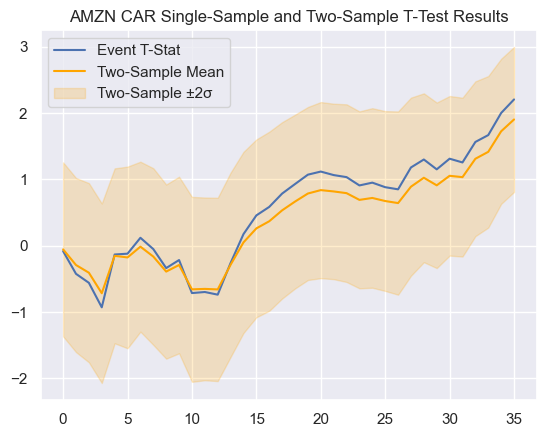

In [19]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

From the above figures, similar to Rigetti, the apparent result is that it takes slightly longer to see significant deviation frmo the pseudo-event mean returns. Let us look at the p-value plot for AMZN's single-sample t-test.

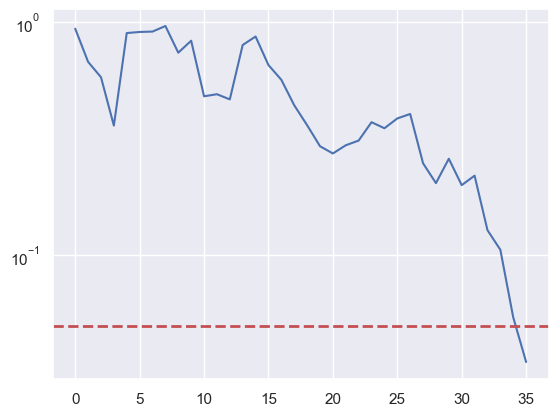

In [20]:
_ = results['p_value'].plot(logy=True)
_ = plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p=0.05')

Similar to Rigetti, we find that the apparent devaition from the mean does not yield statistical significance by measurement of the p-values for the experiment window. We can see that there is a steady decline in the p-value after a window length of ~15, and we drop below our significance line at ~35, so perhaps a longer time horizon should be investigated for AMZN.

## D-Wave and IBM – The Challenge Cases

From data exploration, D-Wave and IBM pose interesting challenges for how we have set up the framework for this study. The results of the following analysis are mainly for my own practice in applying alternate methods of analysis when sample sizes are short.

IBM and D-Wave represent two of the more popular and accessible QC platforms. As a result, the number of publications that are related to the two are tremendous, and we are left with a lot of event days. On the other side of that coin, there are very few pseudo-event dates for us to choose from given our current criteria, as the frequency of publications leaves few dates that are +/- 10 days from a publication (in the case of IBM you can find two dates that are not within +/- two days). As a result, when we go to sample $n$ events such that we sample the same amout as events, it is not possible. Sampling with less samples is already not ideal and should make anyone skeptical of the results, so to practice some alternate methods (and to practice making more generalized code for flexible user operation), I added the capabilty to sample **with replacement** to our random tests.

We will walk through D-Wave first and then we will look at IBM.

### D-Wave

In [7]:
ticker = 'QBTS'
dwave_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=dwave_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv(query="Quantum AND D-Wave Quantum", start_date="2021-01-01", max_results=500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [22]:
windows = [i for i in range(36)]

ev_dwave = EventStudy(ticker, market_returns, windows)

In [23]:
ev_dwave.fit_residuals(stock_returns=dwave_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


In [24]:
filtered_dates = []
for idx in dwave_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('10d')):
            filtered_dates.append(idx)
print(f"Number of pseudo-events : {len(filtered_dates)}")
print(f"Number of events : {len(list(set(arxiv_df.index)))}")

Number of pseudo-events : 12
Number of events : 381


We can see that with our +/- 10 day window, the number of events to pseudo-events is almost 3:1. Let's try keeping these contraints and just add replacement:

In [ ]:

results = ev_dwave.event_single_test(event_dates=list(set(arxiv_df.index)))
mean_random, std_random = ev_dwave.random_single_test(filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

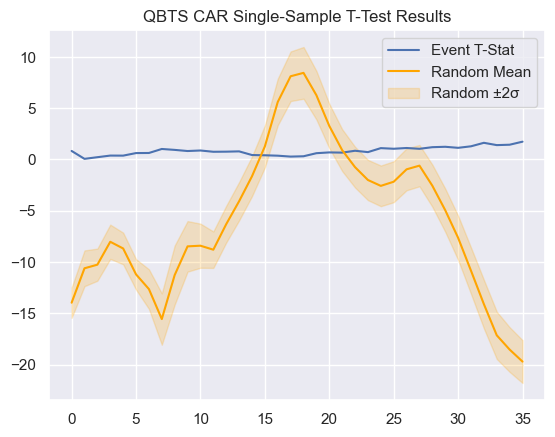

In [26]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [27]:
mean_two_sample, std_two_sample = ev_dwave.event_two_sample_test(event_dates=list(set(arxiv_df.index)), filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

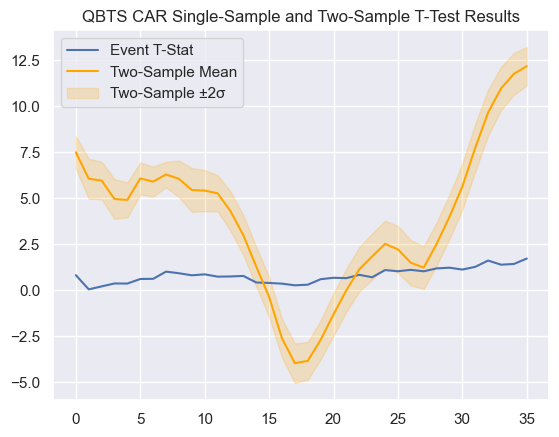

In [28]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

We can see that the results of resampling the 12 pseudo-event days found produces unrealistic results from our t-tests. We can instead focus on just the single-sample t-test results from the event-dates:

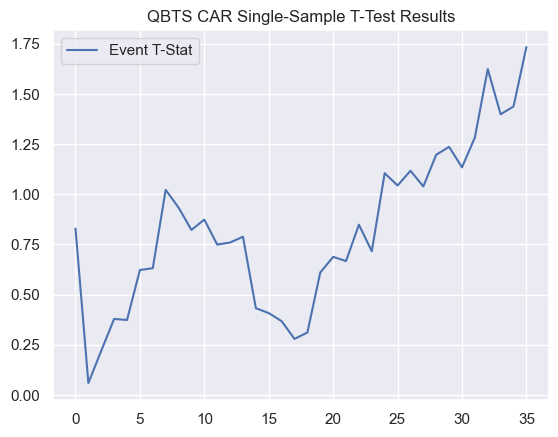

In [30]:
plot_test_results(ticker, results, single_test=True, enable_plotly=False)

From the plot we see a positive deviation from mean 0 for window lengths greater than length ~17. Let us look at the corresponding p-values for each of the tests to see the significance:

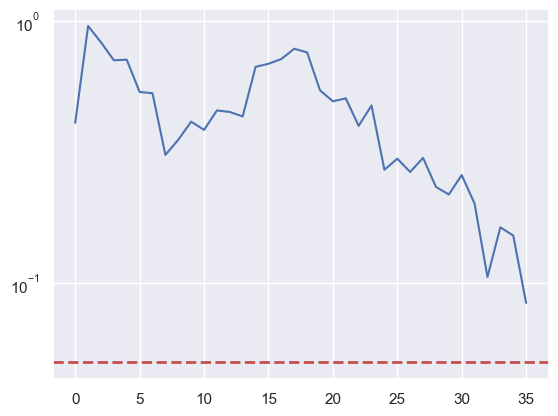

In [29]:
_ = results['p_value'].plot(logy=True)
_ = plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p=0.05')

From the p-value plot above, we can see that our single-sample results are indicating we cannot reject $H_0$ for D-Wave.

While we can use just the results of the single-sample t-test for event days (since the number of events is still sufficiently less than the number of trading days in our returns dataset), let us explore how the distribution of pseudo-events change if we decrease our sensitivty of selecting a pseudo-event from +/- 10 days to +/- 5 days:

In [31]:
filtered_dates = []
for idx in dwave_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('5d')):
            filtered_dates.append(idx)
print(f"Number of pseudo-events : {len(filtered_dates)}")
print(f"Number of events : {len(list(set(arxiv_df.index)))}")

Number of pseudo-events : 97
Number of events : 381


By decreasing our sensitivty to 5-days, we were able to include an additional 85 pseudo-events. As a result though, the likelihood of bleed over from event dates into publication dates increasing, adding less confidence to the resulting comparison to random results and the two-sample test. We are more likely to see in the two-sample t-test results converge on the single-sample t-test for the event dates since there will be more overlap in the CAR windows between the two poopulation samples. Regardless, for the sake of exploration, let us examine what would happen in the plots:

In [32]:

results = ev_dwave.event_single_test(event_dates=list(set(arxiv_df.index)))
mean_random, std_random = ev_dwave.random_single_test(filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

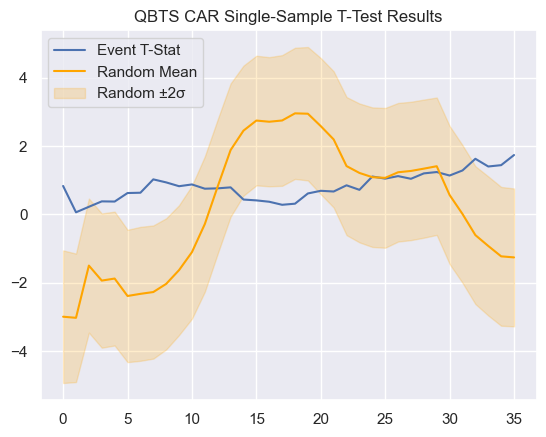

In [33]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [34]:
mean_two_sample, std_two_sample = ev_dwave.event_two_sample_test(event_dates=list(set(arxiv_df.index)), filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

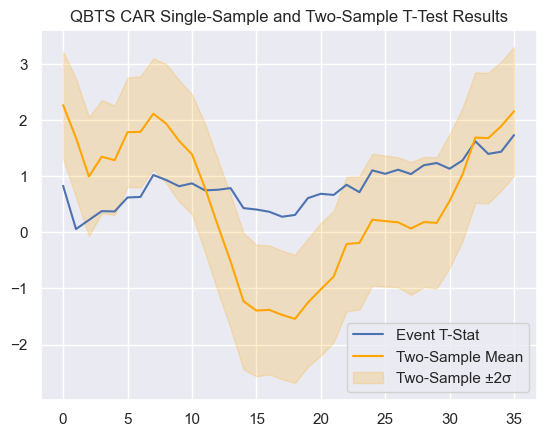

In [35]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

The results for the random t-test and the two-sample t-test mean (and +/- two standard deviation bands) appear to be closer to something we would expect in a typical sampling of pseudo events, however, there is still replacement occuring which is biasing our pseudo-samples. Additionally, since we have decreased our sensitivity, the results are likely taking on some of the event-driven outcomes returns, also biasing our pseudo-events. Before moving on, we can quickly run two more cases: one with a further descreased sensitivity of +/- 2 days gap from pubilcation events, and one where we stay at +/- 5, and we do not resample, but rather just sample the number of pseudo-days, rather than trying to match the number of samples to the number of events:

In [46]:
## 5-day sensitivity with lower n
mean_two_sample, std_two_sample = ev_dwave.event_two_sample_test(event_dates=list(set(arxiv_df.index)), filtered_dates=filtered_dates, n=len(filtered_dates), M=1, replacement=False)

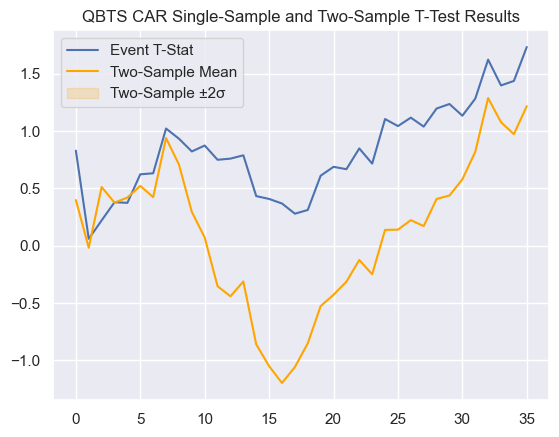

In [47]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

In teh call to the two-sample test, we can see that the parameter `M` has been set to `1`. This is because since we are making `n` equal to the number of pseudo-events, when we sample without replacement, we are simply sampling the entire span of pseudo-events, so every iteration of it will be the same. This is why there is no +/- 2 standard deviation band: the standard deviation of one sample is 0. This can be seen from the formula for the standard deviation
$$
\sigma_x = \sqrt{\sum_i (x_i - \bar{x})^2}.
$$
In this case, $x_i = \bar{x}$, so we get $\sum_i 0 = 0$, giving a variance and standard deviation of zero. This is not an ideal comparison.

Lets now try with the decreased sensitivity:

In [42]:
## 2-day sensitivity with replacement
filtered_dates = []
for idx in dwave_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('2d')):
            filtered_dates.append(idx)
print(f"Number of pseudo-events : {len(filtered_dates)}")
print(f"Number of events : {len(list(set(arxiv_df.index)))}")

mean_two_sample, std_two_sample = ev_dwave.event_two_sample_test(event_dates=list(set(arxiv_df.index)), filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

Number of pseudo-events : 329
Number of events : 381


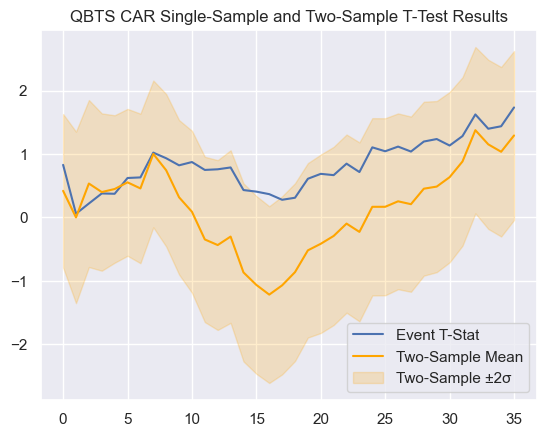

In [43]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

The above plot shows that when we decrease our sensitivity to +/- two days from an event for selecting our pseudo-events, the the mean t-score starts to converge on the single sample event t-score. This is expected as we are introducing further bias into our pseudo event by blending the overlap of event and pseudo-events further. This results in less confidence in claiming independence of the event returns from the pseudo-event returns, so the addition of the two-sample results here with the single-sample event results does not add much statistical proof to our hypothesis (it actually further's our inability to disregard $H_0$).

## IBM

We have gone through a more extensive exploration with D-Wave, so we will keep IBM a bit more brief. Quickly we will see that IBM comes to the same problem of requiring lower sensitivity with replacement sampling to carry out the same analysis. Interestingly, the arXiv python package was unable to return all papers published by IBM during the time frame do to a request limit issue with the api. This portion introduce a raw scraper using `feedparser` and manually building a api query url to get results, which seems to work better for this. 

In [2]:
ticker = 'IBM'
ibm_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=ibm_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv_raw(
    query="Quantum AND IBM+Quantum",
    start_year=2021,
    end_year=2025,
    max_results_per_year=2000,
    batch_size=200,
    delay=0.8,
    save_data=False,
)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
windows = [i for i in range(36)]

ev_ibm = EventStudy(ticker, market_returns, windows)

In [4]:
ev_ibm.fit_residuals(stock_returns=ibm_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


In [11]:
filtered_dates = []
for idx in ibm_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('2d')):
            filtered_dates.append(idx)

print(f"Number of pseudo-events : {len(filtered_dates)}")
print(f"Number of events : {len(list(set(arxiv_df.index)))}")  

Number of pseudo-events : 126
Number of events : 645


In [12]:
arxiv_df

,title,authors,url
published,,,
2021-01-02,Graph Picture of Linear Quantum Networks and E...,"[Seungbeom Chin, Yong-Su Kim, Sangmin Lee]",http://arxiv.org/abs/2101.00392v3
2021-01-07,Modeling and mitigation of cross-talk effects ...,"[Filip B. Maciejewski, Flavio Baccari, Zoltán ...",http://arxiv.org/abs/2101.02331v3
2021-01-08,Experimental Quantum Enhanced Optical Interfer...,[Marco Genovese],http://arxiv.org/abs/2101.02891v1
2021-01-13,A general quantum algorithm for open quantum d...,"[Zixuan Hu, Kade Head-Marsden, David A. Mazzio...",http://arxiv.org/abs/2101.05287v3
2021-01-14,Secure Multi-Party Quantum Conference and Xor ...,"[Nayana Das, Goutam Paul]",http://arxiv.org/abs/2101.05560v1
...,...,...,...
2025-10-21,Information geometry of nonmonotonic quantum n...,[Hideyuki Miyahara],http://arxiv.org/abs/2510.18286v1
2025-10-22,Revealing the quantum nature of memory in non-...,"[Charlotte Bäcker, Krishna Palaparthy, Walter ...",http://arxiv.org/abs/2510.19522v1
2025-10-23,Quantum Processing Unit (QPU) processing time ...,"[Lucy Xing, Sanjay Vishwakarma, David Kremer, ...",http://arxiv.org/abs/2510.20630v1


In [ ]:
        
results = ev_ibm.event_single_test(event_dates=list(set(arxiv_df.index)))
mean_random, std_random = ev_ibm.random_single_test(filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

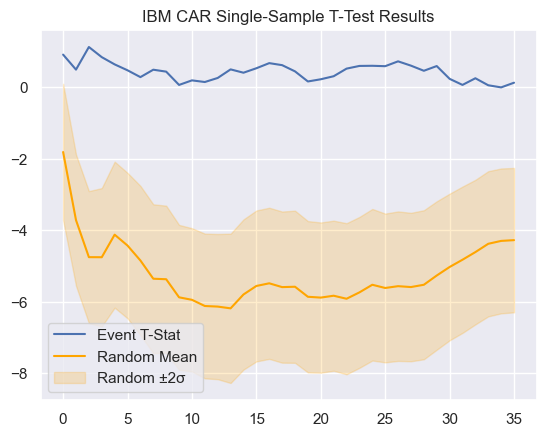

In [ ]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [ ]:
mean_two_sample, std_two_sample = ev_ibm.event_two_sample_test(event_dates=list(set(arxiv_df.index)), filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

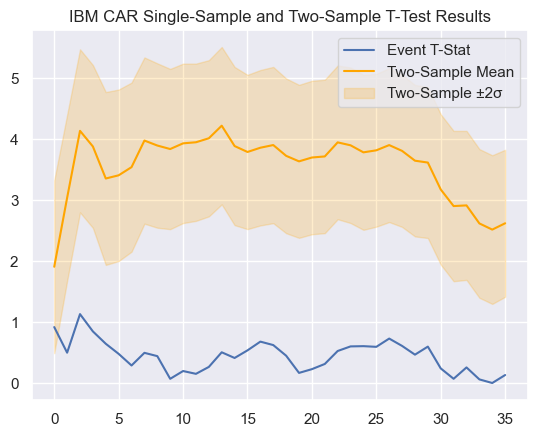

In [ ]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)